In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer


In [12]:
# Load pre-trained ResNet model and tokenizer, model for caption generation
resnet_model = resnet50(pretrained=True)
resnet_model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
caption_model = VisionEncoderDecoderModel.from_pretrained('nlpconnect/vit-gpt2-image-captioning')



preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

In [14]:
# Define image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

In [15]:
# Function to extract image features using ResNet
def extract_image_features(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        features = resnet_model(image)
    return features


In [16]:
# Function to generate captions from image features
def generate_caption(image_path):
    image = Image.open(image_path).convert('RGB')
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values

    with torch.no_grad():
        outputs = caption_model.generate(pixel_values, max_length=50, num_beams=5, early_stopping=True)

    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return caption

In [8]:
from google.colab import files
import io

In [9]:
uploaded = files.upload()

Saving boy-playing-cricket.jpg to boy-playing-cricket (1).jpg


In [18]:
import matplotlib.pyplot as plt

In [19]:
def display_image_with_caption(image_path, caption):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, fontsize=15, wrap=True)
    plt.show()

Generated Caption: a young boy swinging a baseball bat on top of a field 


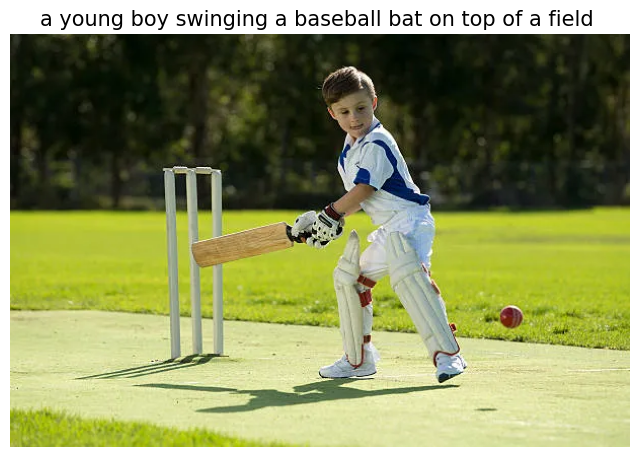

In [20]:

image_path = 'boy-playing-cricket.jpg'
caption = generate_caption(image_path)
print(f'Generated Caption: {caption}')
display_image_with_caption(image_path, caption)